![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [240]:
# Import standard packages
import pandas as pd
import numpy as np
import datetime
import re

import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt

In [241]:
# Establish connection to the IMDB .db file
conn = sqlite3.connect('zippedData/im.db')
cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [242]:
# Read in and inspect `movie_basics` and `movie_ratings` tables
# this will be our master table and will left join on this set
df_movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
df_movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [243]:
# Read in and inspect movie_ratings table
df_movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
df_movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [244]:
# Our analysis will use data from movies released between 2010 and 2018
df_movie_basics = df_movie_basics[(df_movie_basics['start_year'] >= 2010) & (df_movie_basics['start_year'] <= 2018)]

In [245]:
# Do a left join pulling in df_movie_ratings
merged_df = pd.merge(df_movie_basics, df_movie_ratings, on='movie_id', how='left')

In [246]:
# Read in movie budgets
df_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')
df_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [247]:
# Create new column for 'year' in df_movie_budgets to key off + 'title' to join with merged_df
df_movie_budgets['year'] = df_movie_budgets['release_date'].str[-4:]
df_movie_budgets['year'] = pd.to_numeric(df_movie_budgets['year'], downcast='integer')

In [248]:
# Join the merged tables with our budgets df
merged_df = merged_df.merge(df_movie_budgets, how = 'left', left_on = ['primary_title', 'start_year'], 
                            right_on = ['movie', 'year'])

In [249]:
# Drop rows that don't have production budget data
merged_df = merged_df.dropna(subset=['production_budget'])

In [250]:
# Drop redundant title and year columns
merged_df.drop(columns=['movie','year'],
               axis='columns', inplace=True)
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
19,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248.0,26.0,"Dec 31, 2012","$45,000,000",$0,"$73,706"
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,37.0,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,67.0,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587"
56,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0,34.0,"Jun 12, 2015","$215,000,000","$652,270,625","$1,648,854,864"
58,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787.0,16.0,"Oct 28, 2011","$45,000,000","$13,109,815","$21,544,732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127625,tt8408152,Detention,Detention,2012,NaN,Horror,NaN,NaN,45.0,"Apr 13, 2012","$10,000,000",$0,$0
129399,tt8632862,Fahrenheit 11/9,Fahrenheit 11/9,2018,128.0,Documentary,6.7,11628.0,29.0,"Sep 21, 2018","$5,000,000","$6,352,306","$6,653,715"
131109,tt8852552,Icarus,Icarus,2010,78.0,Thriller,NaN,NaN,91.0,"Feb 9, 2010","$6,000,000",$0,$0
134493,tt9347476,Believe,Believe,2016,NaN,None,NaN,NaN,13.0,"Dec 2, 2016","$3,500,000","$890,303","$890,303"


In [251]:
# Drop rows with null values and inspect info
merged_df.dropna(inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 19 to 129399
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1457 non-null   object 
 1   primary_title      1457 non-null   object 
 2   original_title     1457 non-null   object 
 3   start_year         1457 non-null   int64  
 4   runtime_minutes    1457 non-null   float64
 5   genres             1457 non-null   object 
 6   averagerating      1457 non-null   float64
 7   numvotes           1457 non-null   float64
 8   id                 1457 non-null   float64
 9   release_date       1457 non-null   object 
 10  production_budget  1457 non-null   object 
 11  domestic_gross     1457 non-null   object 
 12  worldwide_gross    1457 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 159.4+ KB


In [252]:
# Convert runtime_minutes and numvotes from float to int
merged_df = merged_df.astype({"runtime_minutes" : "int", "numvotes": "int"})
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,"Dec 31, 2012","$45,000,000",$0,"$73,706"
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587"
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,"Jun 12, 2015","$215,000,000","$652,270,625","$1,648,854,864"
58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,"Oct 28, 2011","$45,000,000","$13,109,815","$21,544,732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121683,tt7784604,Hereditary,Hereditary,2018,127,"Drama,Horror,Mystery",7.3,151571,56.0,"Jun 8, 2018","$10,000,000","$44,069,456","$70,133,905"
121697,tt7785302,Spotlight,Spotlight,2015,99,Drama,8.0,12,34.0,"Nov 6, 2015","$20,000,000","$45,055,776","$92,088,460"
123478,tt7959026,The Mule,The Mule,2018,116,"Crime,Drama,Thriller",7.1,58955,100.0,"Dec 14, 2018","$50,000,000","$103,804,407","$170,857,676"
124315,tt8043306,Teefa in Trouble,Teefa in Trouble,2018,155,"Action,Comedy,Crime",7.4,2724,8.0,"Jul 20, 2018","$1,500,000",$0,"$98,806"


In [253]:
# Remove dollar signs from financial columns and cast financial data to integer type
merged_df['worldwide_gross'] = merged_df['worldwide_gross'].replace( '[^0-9]', '', regex=True)
merged_df['domestic_gross'] = merged_df['domestic_gross'].replace( '[^0-9]', '', regex=True)
merged_df['production_budget'] = merged_df['production_budget'].replace( '[^0-9]', '', regex=True)
merged_df['production_budget'] = merged_df['production_budget'].astype(int)
merged_df['domestic_gross'] = merged_df['domestic_gross'].astype(int)
merged_df['worldwide_gross'] = merged_df['worldwide_gross'].astype(int)


In [254]:
# Create Revenue Index column which is the ration of gross revenue to budget for a given title
merged_df['revenue_index'] = merged_df['worldwide_gross'] / merged_df['production_budget']
merged_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,revenue_index
19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,"Dec 31, 2012",45000000,0,73706,0.001638
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,"Dec 25, 2013",91000000,58236838,187861183,2.064409
54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,"Sep 19, 2014",28000000,26017685,62108587,2.218164
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,"Jun 12, 2015",215000000,652270625,1648854864,7.669092
58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,"Oct 28, 2011",45000000,13109815,21544732,0.478772


In [255]:
# Reset the DF index 
merged_df.reset_index()

,index,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,revenue_index
0,19,tt0249516,Foodfight!,Foodfight!,2012,91,"Action,Animation,Comedy",1.9,8248,26.0,"Dec 31, 2012",45000000,0,73706,0.001638
1,50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,"Dec 25, 2013",91000000,58236838,187861183,2.064409
2,54,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.5,105116,67.0,"Sep 19, 2014",28000000,26017685,62108587,2.218164
3,56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,"Jun 12, 2015",215000000,652270625,1648854864,7.669092
4,58,tt0376136,The Rum Diary,The Rum Diary,2011,119,"Comedy,Drama",6.2,94787,16.0,"Oct 28, 2011",45000000,13109815,21544732,0.478772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,121683,tt7784604,Hereditary,Hereditary,2018,127,"Drama,Horror,Mystery",7.3,151571,56.0,"Jun 8, 2018",10000000,44069456,70133905,7.013390
1453,121697,tt7785302,Spotlight,Spotlight,2015,99,Drama,8.0,12,34.0,"Nov 6, 2015",20000000,45055776,92088460,4.604423
1454,123478,tt7959026,The Mule,The Mule,2018,116,"Crime,Drama,Thriller",7.1,58955,100.0,"Dec 14, 2018",50000000,103804407,170857676,3.417154
1455,124315,tt8043306,Teefa in Trouble,Teefa in Trouble,2018,155,"Action,Comedy,Crime",7.4,2724,8.0,"Jul 20, 2018",1500000,0,98806,0.065871


In [256]:
# Convert financial columns unit from dollars to million dollars
merged_df['production_budget'] = merged_df['production_budget']/1000000
merged_df['domestic_gross'] = merged_df['domestic_gross']/1000000
merged_df['worldwide_gross'] = merged_df['worldwide_gross']/1000000

In [257]:
# Split the genre column out into 3 columns 
merged_df[['genre1', 'genre2', 'genre3']] = merged_df['genres'].str.split(',', expand=True)

In [258]:
# Display stats description of worldwide_gross column to see top 25% threshold
merged_df.worldwide_gross.describe() # $160,000,000 is the top quartile in earned

count    1457.000000
mean      141.963901
std       235.240974
min         0.000000
25%         8.217571
50%        52.460543
75%       159.946489
max      2048.134200
Name: worldwide_gross, dtype: float64

In [259]:
# Display stats description of revenue_index column to see top 25% threshold
merged_df.revenue_index.describe()  # 4 is the top quartile in revenue index

count    1457.000000
mean        3.691895
std        12.182487
min         0.000000
25%         0.744915
50%         2.135069
75%         4.004564
max       416.564740
Name: revenue_index, dtype: float64

In [260]:
# Create a new df that only has top quartile in both revenue index and worldwide gross revenue
over_100_gross = merged_df.loc[(merged_df['worldwide_gross'] > 160) & (merged_df['revenue_index'] > 4)]
over_100_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 56 to 112595
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           179 non-null    object 
 1   primary_title      179 non-null    object 
 2   original_title     179 non-null    object 
 3   start_year         179 non-null    int64  
 4   runtime_minutes    179 non-null    int64  
 5   genres             179 non-null    object 
 6   averagerating      179 non-null    float64
 7   numvotes           179 non-null    int64  
 8   id                 179 non-null    float64
 9   release_date       179 non-null    object 
 10  production_budget  179 non-null    float64
 11  domestic_gross     179 non-null    float64
 12  worldwide_gross    179 non-null    float64
 13  revenue_index      179 non-null    float64
 14  genre1             179 non-null    object 
 15  genre2             173 non-null    object 
 16  genre3             140

In [261]:
# Inspect stats descripiton for production budgets to define high budget films
merged_df['production_budget'].describe()# budgets of $55 million are top quartile and considered high budget

count    1457.000000
mean       44.398509
std        55.690601
min         0.015000
25%         8.000000
50%        23.000000
75%        55.000000
max       410.600000
Name: production_budget, dtype: float64

In [262]:
# Isolate high budget films in a new df
high_budget_df = merged_df.loc[(merged_df['production_budget'] > 55)]

In [263]:
# Melt the dataframe to convert the genre columns to rows
genres_pi = merged_df.melt(id_vars=['revenue_index'], value_vars=['genre1', 'genre2', 'genre3'])
genres__pi_top_100 = over_100_gross.melt(id_vars=['revenue_index'], value_vars=['genre1', 'genre2', 'genre3'])
genres_pi_high_budget = high_budget_df.melt(id_vars=['revenue_index'], value_vars=['genre1', 'genre2', 'genre3'])

# Group the dataframe by the 'value' column, which is the new column created by the melt function
genres_pi = genres_pi.groupby('value').agg({'revenue_index': ['mean']}).reset_index()
genres__pi_top_100 = genres__pi_top_100.groupby('value').agg({'revenue_index': ['mean']}).reset_index()
genres_pi_high_budget = genres_pi_high_budget.groupby('value').agg({'revenue_index': ['mean']}).reset_index()

# Rename the columns of the dataframe
genres_pi.columns = ['genre', 'average_revenue_index']
genres__pi_top_100.columns = ['genre', 'average_revenue_index']
genres_pi_high_budget.columns = ['genre', 'average_revenue_index']

# Do the same for worldwide_gross
genres_gross = merged_df.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])
genres_gross_top_100 = over_100_gross.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])
genres_gross_high_budget = high_budget_df.melt(id_vars=['worldwide_gross'], value_vars=['genre1', 'genre2', 'genre3'])

# Group the dataframe by the 'value' column, which is the new column created by the melt function
genres_gross = genres_gross.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()
genres_gross_top_100 = genres_gross_top_100.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()
genres_gross_high_budget = genres_gross_high_budget.groupby('value').agg({'worldwide_gross': ['mean']}).reset_index()

# Rename the columns of the dataframe
genres_gross.columns = ['genre', 'average_gross']
genres_gross_top_100.columns = ['genre', 'average_gross']
genres_gross_high_budget.columns = ['genre', 'average_gross']


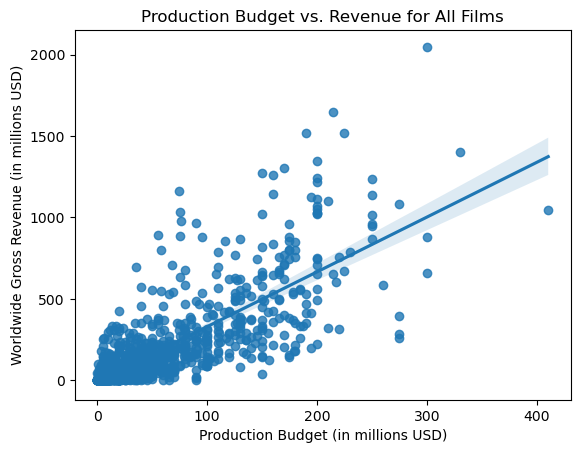

In [300]:
# Create a regression plot for Production Budget vs Revenue for all films
sns.regplot(x='production_budget', y='worldwide_gross', data=merged_df)
plt.xlabel('Production Budget (in millions USD)')
plt.ylabel('Worldwide Gross Revenue (in millions USD)')
plt.title('Production Budget vs. Revenue for All Films')

plt.savefig('imgs/Production Budget vs. Revenue for All Films.png')

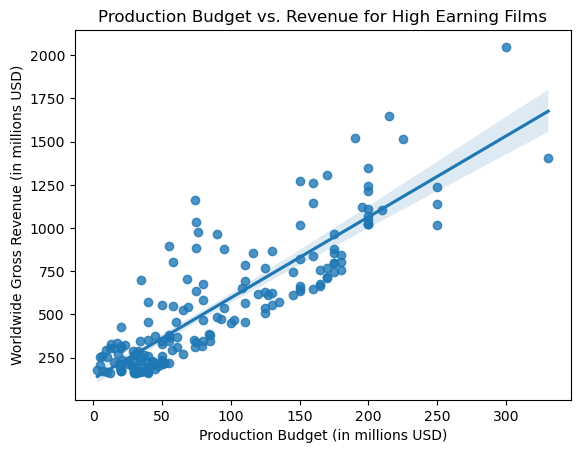

In [301]:
# Create a regression plot for Production Budget vs Revenue for high grossing films
sns.regplot(x='production_budget', y='worldwide_gross', data=over_100_gross)
plt.xlabel('Production Budget (in millions USD)')
plt.ylabel('Worldwide Gross Revenue (in millions USD)')
plt.title('Production Budget vs. Revenue for High Earning Films')

plt.savefig('imgs/Production Budget vs. Revenue for High Earning Films.png')

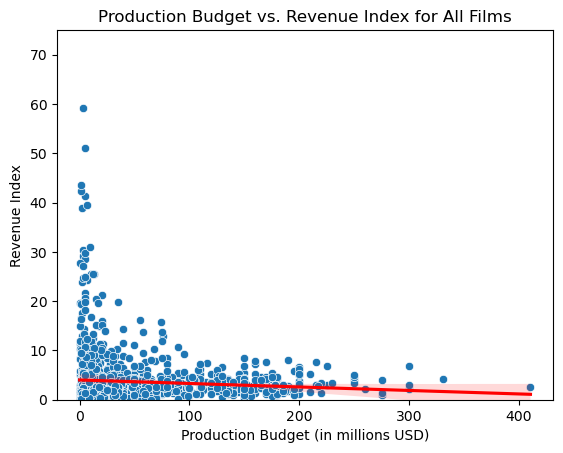

In [303]:
# Create a regression plot for Production Budget vs Revenue Index for all films
sns.scatterplot(x='production_budget', y='revenue_index', data=merged_df, zorder=1)
plt.ylim(0, 75)
sns.regplot(x='production_budget', y='revenue_index', data=merged_df, color='red', scatter=False)
plt.title('Production Budget vs. Revenue Index for All Films')
plt.xlabel('Production Budget (in millions USD)')
plt.ylabel('Revenue Index')

plt.savefig('imgs/Production Budget vs. Revenue Index for All Films.png')

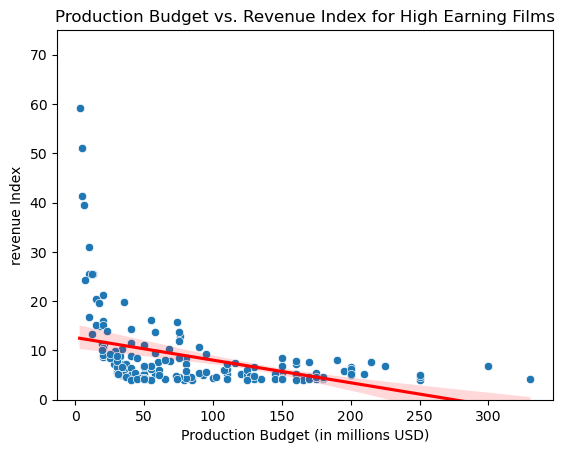

In [304]:
# Create a regression plot for Production Budget vs Revenue Index for high grossing films
sns.scatterplot(x='production_budget', y='revenue_index', data=over_100_gross, zorder=1)
plt.ylim(0, 75)
sns.regplot(x='production_budget', y='revenue_index', data=over_100_gross , color='red', scatter=False)
plt.title('Production Budget vs. Revenue Index for High Earning Films')
plt.xlabel('Production Budget (in millions USD)')
plt.ylabel('revenue Index')

plt.savefig('imgs/Production Budget vs. Revenue Index for High Earning Films.png')

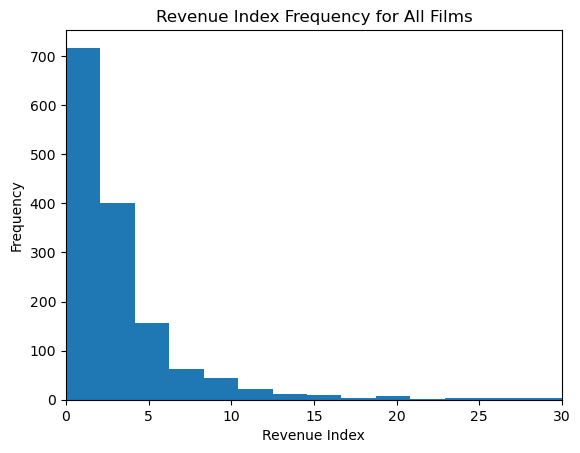

In [305]:
# Create histogram for Revenue Index frequency
plt.hist(merged_df['revenue_index'],bins=200)
plt.xlabel('Revenue Index')
plt.ylabel('Frequency')
plt.title('Revenue Index Frequency for All Films')
plt.xlim(0,30)

plt.savefig('imgs/Revenue Index Frequency for All Films.png')

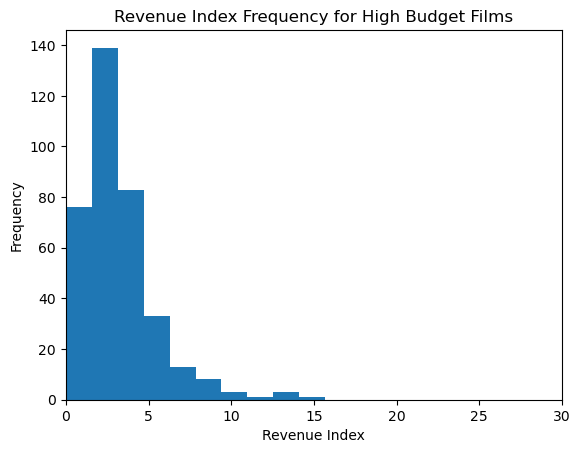

In [306]:
# Create histogram for Revenue Index frequency for high budget films
plt.hist(high_budget_df['revenue_index'],bins=10)
plt.xlabel('Revenue Index')
plt.ylabel('Frequency')
plt.title('Revenue Index Frequency for High Budget Films')
plt.xlim(0,30) # Distributions of the histogram are similar in shape for both sets

plt.savefig('imgs/Revenue Index Frequency for High Budget Films.png')

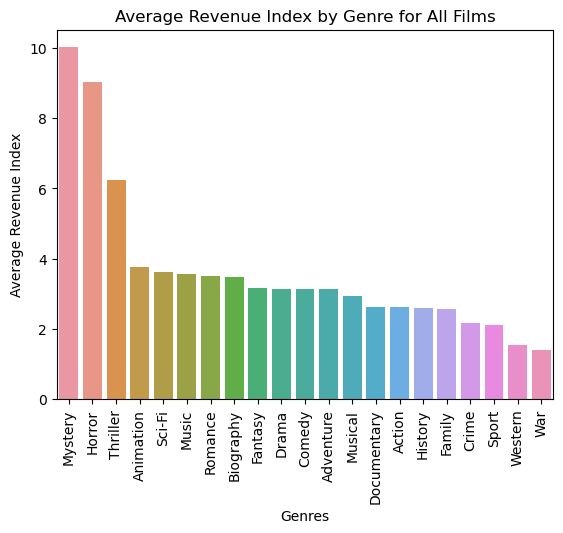

In [308]:
# From the graphs above, we have shown that revenue index is generally the same for all films vs. high budget
# and bigger bets will make us more money, especially for a company like Microsoft. 
# So if we go high budget, what kind of films to make?
sorted_revenue = genres_pi.sort_values('average_revenue_index', ascending=False)
x=sorted_revenue['genre']

sns.barplot(x=x, y='average_revenue_index', data=sorted_revenue)

plt.xlabel('Genres')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index by Genre for All Films')
plt.xticks(rotation=90)
plt.savefig('imgs/avg_rev_index_all.png')
plt.show()

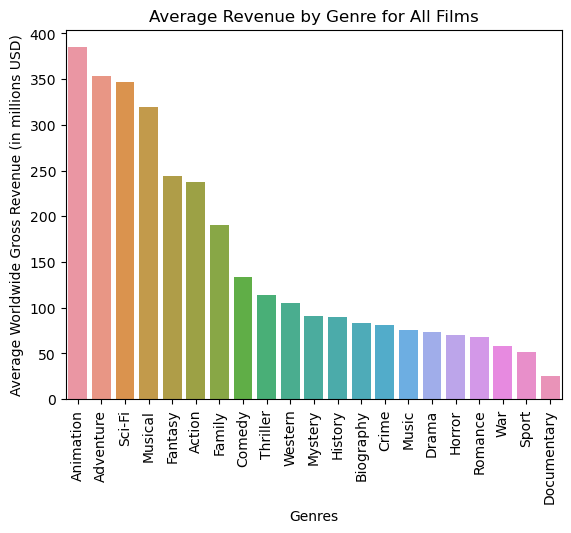

In [309]:
# Plot Average Revenue by Genre for All Films
sorted_gross = genres_gross.sort_values('average_gross', ascending=False)
x=sorted_gross['genre']

sns.barplot(x=x, y='average_gross', data=genres_gross)
plt.xlabel('Genres')
plt.ylabel('Average Worldwide Gross Revenue (in millions USD)')
plt.title('Average Revenue by Genre for All Films')
plt.xticks(rotation=90)

plt.savefig('imgs/avg_rev_all.png')
plt.show()

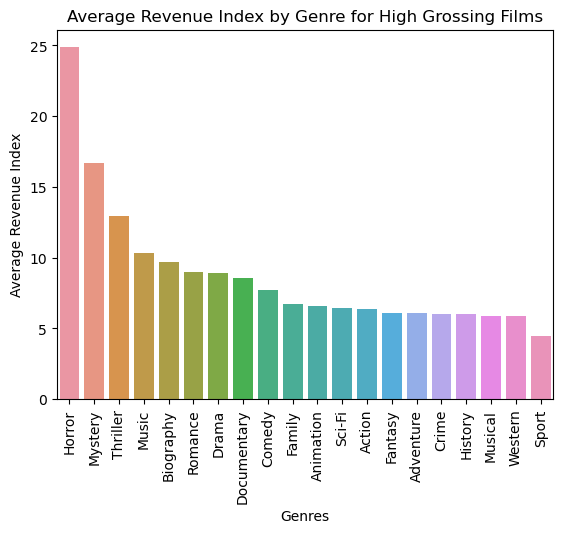

In [311]:
# Plot Average Revenue Index by Genre for High Grossing Films
sorted_avg_index = genres__pi_top_100.sort_values('average_revenue_index', ascending=False)
x=sorted_avg_index['genre']

sns.barplot(x=x, y='average_revenue_index', data=genres__pi_top_100)
plt.xlabel('Genres')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index by Genre for High Grossing Films')
plt.xticks(rotation=90)

plt.savefig('imgs/avg_rev_index_high_grossing.png')
plt.show()

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/4203742448.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x=sorted_avg_gross['genre'][1:]


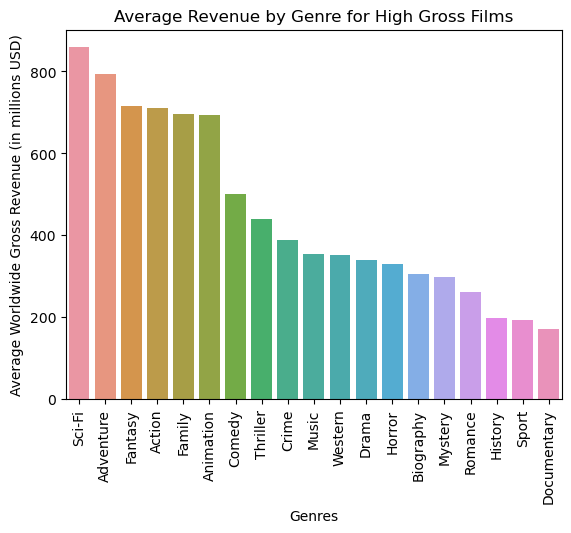

In [312]:
# Plot Average Revenue by Genre for High Grossing Films
sorted_avg_gross = genres_gross_top_100.sort_values('average_gross', ascending=False)
#Scrub Musicals
x=sorted_avg_gross['genre'][1:]

sns.barplot(x=x, y='average_gross', data=genres_gross_top_100)
plt.xlabel('Genres')
plt.ylabel('Average Worldwide Gross Revenue (in millions USD)')
plt.title('Average Revenue by Genre for High Gross Films')
plt.xticks(rotation=90)

plt.savefig('imgs/avg_rev_high_grossing.png')
plt.show()

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/1986373741.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x=sorted_high_budget_index['genre'][1:]


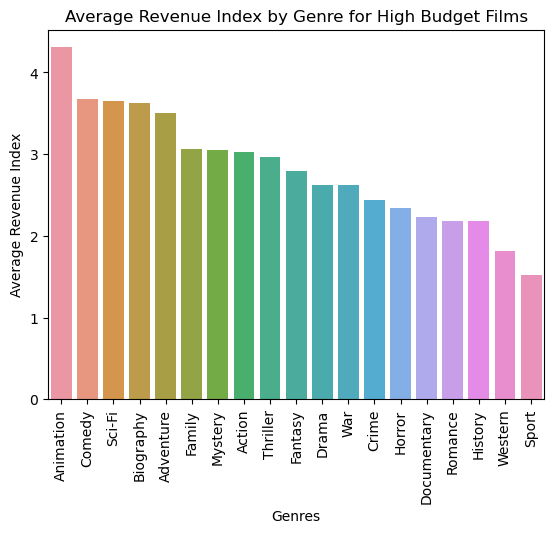

In [313]:
# Plot Average Revenue Index by Genre for High Budge Films
sorted_high_budget_index = genres_pi_high_budget.sort_values('average_revenue_index', ascending=False)
#Scrub Musicals
x=sorted_high_budget_index['genre'][1:]

sns.barplot(x=x, y='average_revenue_index', data=genres_pi_high_budget)
plt.xlabel('Genres')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index by Genre for High Budget Films')
plt.xticks(rotation=90)

plt.savefig('imgs/Average Revenue Index by Genre for High Budget Films.png')
plt.show()

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/1579820357.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x=sorted_high_budget_gross['genre'][1:]


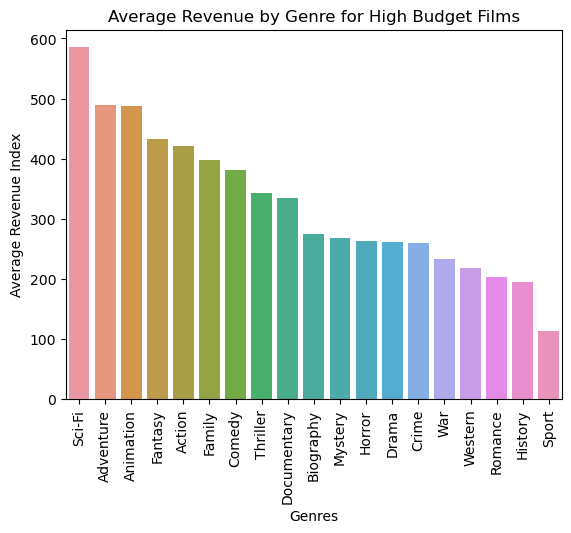

In [314]:
# Plot Average Revenue by Genre for High Budget Films
sorted_high_budget_gross = genres_gross_high_budget.sort_values('average_gross', ascending=False)
#Scrub Musicals
x=sorted_high_budget_gross['genre'][1:]

sns.barplot(x=x, y='average_gross', data=genres_gross_high_budget)
plt.xlabel('Genres')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue by Genre for High Budget Films')
plt.xticks(rotation=90)

plt.savefig('imgs/Average Revenue by Genre for High Budget Films.png')
plt.show()

In [315]:
# Read in movie principals csv
merged_principals_df =pd.read_csv('zippedData/merged_principals.csv') 

In [316]:
directors_df = merged_principals_df.loc[merged_principals_df['category'] == 'director']

In [317]:
scifi_high_budget_df = high_budget_df[high_budget_df['genre1'].isin(['Sci-Fi']) | high_budget_df['genre2'].isin(['Sci-Fi']) | high_budget_df['genre3'].isin(['Sci-Fi'])]

In [318]:
scifi_dir_merge = pd.merge(directors_df, scifi_high_budget_df, on='movie_id')
scifi_dir_average_revenue = scifi_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
scifi_dir_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/146369865.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scifi_dir_average_revenue = scifi_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Gary Ross             8.474042
J.A. Bayona           7.681016
Colin Trevorrow       7.669092
Ruben Fleischer       7.358867
Ryan Coogler          6.741291
Alfonso Cuarón        6.306352
Francis Lawrence      5.613867
Joss Whedon           5.495112
Joe Russo             5.196585
Anthony Russo         5.196585
Wes Ball              5.091249
Rupert Wyatt          5.064368
Jon Watts             5.029522
Christopher Nolan     4.630346
Michael Bay           4.599556
Travis Knight         4.560741
Gareth Edwards        4.276120
James Mangold         4.233758
Shane Black           3.944660
Ridley Scott          3.915299
Steven Spielberg      3.861934
Paul W.S. Anderson    3.702271
Jon Favreau           3.653861
Brad Peyton           3.567136
Marc Webb             3.494969
Bryan Singer          3.393639
Jon Turteltaub        2.974892
Zack Snyder           2.968887
Morten Tyldum         2.747633
Chris Columbus        2.711576
Jon M. Chu            2.683862
Joe Johnston          2.64

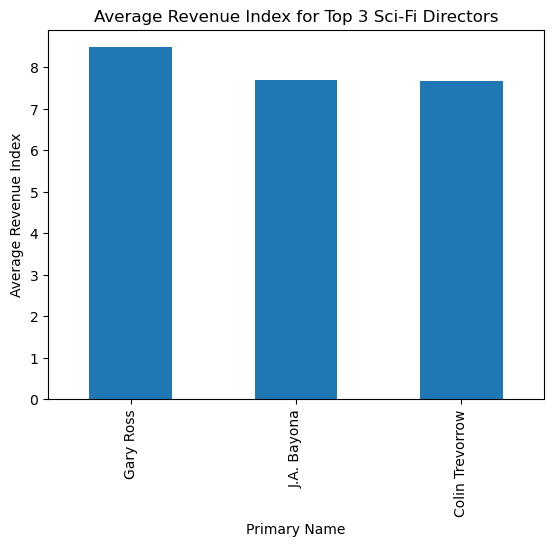

In [319]:
# Chart Top 5 Sci-Fi Directors by Revenue Index
top_5_dir_scifi = scifi_dir_average_revenue.head(3)
top_5_dir_scifi.plot.bar()
plt.xlabel('Primary Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Sci-Fi Directors')

plt.savefig('imgs/Average Revenue Index for Top 3 Sci-Fi Directors.png')
plt.show()

In [320]:
adventure_high_budget_df = high_budget_df[high_budget_df['genre1'].isin(['Adventure']) | high_budget_df['genre2'].isin(['Adventure']) | high_budget_df['genre3'].isin(['Adventure'])]

In [321]:
adventure_dir_merge = pd.merge(directors_df, adventure_high_budget_df, on='movie_id')
adventure_dir_average_revenue = adventure_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
adventure_dir_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/3606922504.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  adventure_dir_average_revenue = adventure_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Kyle Balda          14.738294
Tim Miller          13.810786
Eric Guillon        13.796370
Pierre Coffin       13.314085
Chris Renaud        12.327570
                      ...    
Renny Harlin         0.842190
Marcus Nispel        0.703957
Robert Schwentke     0.608282
Simon Wells          0.263665
Xiao Feng            0.007943
Name: revenue_index, Length: 201, dtype: float64

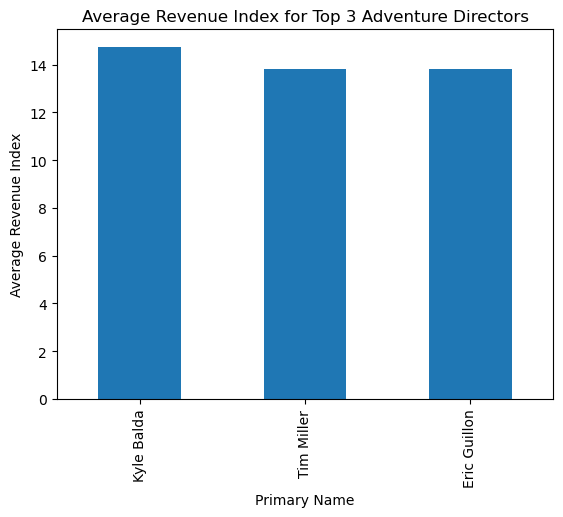

In [322]:
# Chart Top 3 Adventure Directors by Revenue Index
top_5_dir_adventure = adventure_dir_average_revenue.head(3)
top_5_dir_adventure.plot.bar()
plt.xlabel('Primary Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Adventure Directors')

plt.savefig('imgs/Average Revenue Index for Top 3 Adventure Directors.png')
plt.show()

In [323]:
animation_high_budget_df = high_budget_df[high_budget_df['genre1'].isin(['Animation']) | high_budget_df['genre2'].isin(['Animation']) | high_budget_df['genre3'].isin(['Animation'])]

In [324]:
animation_dir_merge = pd.merge(directors_df, animation_high_budget_df, on='movie_id')
animation_dir_average_revenue = animation_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
animation_dir_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/1390725189.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  animation_dir_average_revenue = animation_dir_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Kyle Balda       14.738294
Eric Guillon     13.796370
Yarrow Cheney    11.823340
Pierre Coffin    11.501490
Chris Renaud     10.843813
                   ...    
Zack Snyder       1.397167
Gary Eck          1.170048
George Miller     1.170048
David Peers       1.170048
Simon Wells       0.263665
Name: revenue_index, Length: 89, dtype: float64

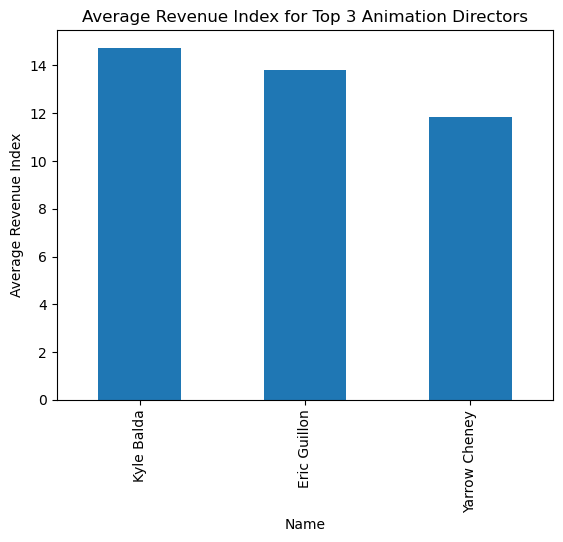

In [325]:
# Chart Top 3 Animation Directors by Revenue Index
top_5_dir_animation = animation_dir_average_revenue.head(3)
top_5_dir_animation.plot.bar()
plt.xlabel('Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Animation Directors')

plt.savefig('imgs/Average Revenue Index for Top 3 Animation Directors')
plt.show()

In [326]:
producers_df = merged_principals_df.loc[merged_principals_df['category'] == 'producer']

In [327]:
scifi_prod_merge = pd.merge(producers_df, scifi_high_budget_df, on='movie_id')
scifi_prod_average_revenue = scifi_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
scifi_prod_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/3952697908.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scifi_prod_average_revenue = scifi_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Belén Atienza      7.681016
Patrick Crowley    7.675054
Jon Kilik          6.328910
Nina Jacobson      6.328910
David Heyman       6.306352
                     ...   
Kate Cohen         1.030393
Lindsey Collins    1.028284
Jim Morris         1.028284
Grant Hill         1.016662
Mark Johnson       0.800926
Name: revenue_index, Length: 66, dtype: float64

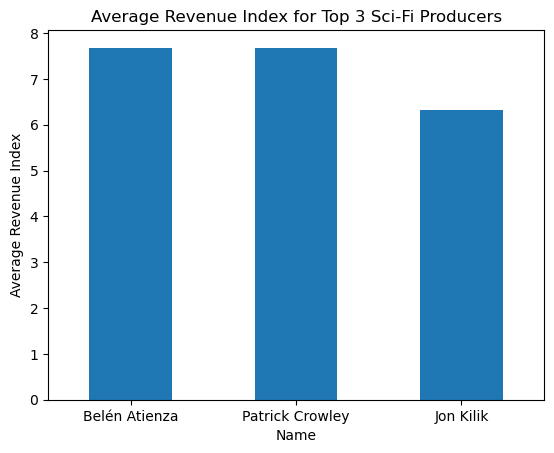

In [328]:
# Chart Top 3 Sci-Fi Producers by Revenue Index
top_5_prod_scifi = scifi_prod_average_revenue.head(3)
top_5_prod_scifi.plot.bar()
plt.xlabel('Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Sci-Fi Producers')
plt.xticks(rotation=0)

plt.savefig('imgs/Average Revenue Index for Top 3 Sci-Fi Producers')
plt.show()

In [329]:
adventure_prod_merge = pd.merge(producers_df, adventure_high_budget_df, on='movie_id')
adventure_prod_average_revenue = adventure_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
adventure_prod_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/2506006200.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  adventure_prod_average_revenue = adventure_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Janet Healy               13.532932
Christopher Meledandri    10.502195
Wyck Godfrey              10.383865
John C. Donkin             9.260686
Simon Kinberg              9.009919
                            ...    
Jack Rapke                 0.263665
Steven J. Boyd             0.263665
Jian-Xiang Shi             0.007943
Stephen J. Eads            0.007943
Haiyang Jiang              0.007943
Name: revenue_index, Length: 189, dtype: float64

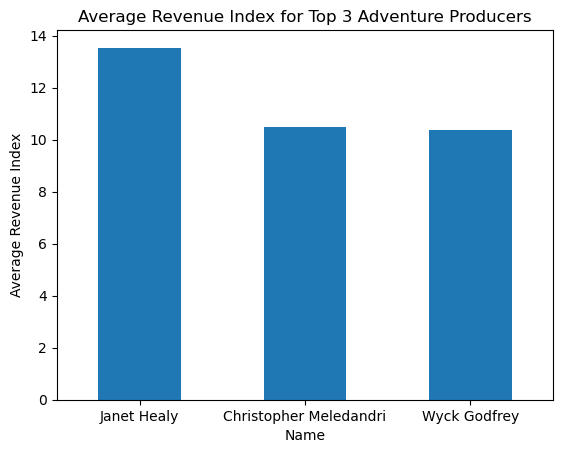

In [330]:
# Chart Top 3 Adventure Producers by Revenue Index
top_5_prod_adventure = adventure_prod_average_revenue.head(3)
top_5_prod_adventure.plot.bar()
plt.xlabel('Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Adventure Producers')
plt.xticks(rotation=0)

plt.savefig('imgs/Average Revenue Index for Top 3 Adventure Producers')
plt.show()

In [331]:
animation_prod_merge = pd.merge(producers_df, animation_high_budget_df, on='movie_id')
animation_prod_average_revenue = animation_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)
animation_prod_average_revenue

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_79350/665375612.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  animation_prod_average_revenue = animation_prod_merge.groupby('primary_name').mean()['revenue_index'].sort_values(ascending=False)


primary_name
Janet Healy               12.518225
Christopher Meledandri     9.991495
John C. Donkin             9.260686
Peter Del Vecho            8.483133
John Cohen                 7.876298
Michelle Murdocca          6.988838
John Walker                6.212604
Nicole Paradis Grindle     6.212604
Lindsey Collins            5.106076
Darla K. Anderson          4.952222
Melissa Cobb               4.432250
Jane Hartwell              4.244951
Kristine Belson            4.244951
Bonnie Arnold              4.238526
Ramsey Ann Naito           4.087030
Kori Rae                   3.717942
Ross Bagdasarian Jr.       3.568014
Mary Ellen Bauder          3.292976
Jordan Kerner              3.292976
Katherine Sarafian         2.997873
Michele Imperato           2.994565
Christopher Jenkins        2.969215
Suzanne Buirgy             2.969215
Peter Jackson              2.876877
Denise Ream                2.800777
Bradford Lewis             2.619335
Paul Feig                  2.526178
Denise Nolan Ca

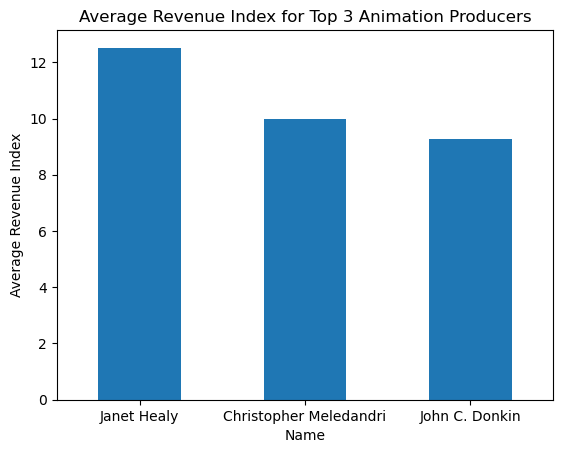

In [333]:
# Chart Top 3 Animation Producers by Revenue Index
top_5_prod_animation = animation_prod_average_revenue.head(3)
top_5_prod_animation.plot.bar()
plt.xlabel('Name')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for Top 3 Animation Producers')
plt.xticks(rotation=0)

plt.savefig('imgs/Average Revenue Index for Top 3 Animation Producers')
plt.show()

In [334]:
high_budget_df.head(100)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,revenue_index,genre1,genre2,genre3
50,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.3,275300,37.0,"Dec 25, 2013",91.0,58.236838,187.861183,2.064409,Adventure,Comedy,Drama
56,tt0369610,Jurassic World,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.0,539338,34.0,"Jun 12, 2015",215.0,652.270625,1648.854864,7.669092,Action,Adventure,Sci-Fi
66,tt0398286,Tangled,Tangled,2010,100,"Adventure,Animation,Comedy",7.8,366366,15.0,"Nov 24, 2010",260.0,200.821936,586.477240,2.255682,Adventure,Animation,Comedy
68,tt0401729,John Carter,John Carter,2012,132,"Action,Adventure,Sci-Fi",6.6,241792,14.0,"Mar 9, 2012",275.0,73.058679,282.778100,1.028284,Action,Adventure,Sci-Fi
87,tt0427152,Dinner for Schmucks,Dinner for Schmucks,2010,114,Comedy,5.9,91546,51.0,"Jul 30, 2010",69.0,73.026337,86.796502,1.257920,Comedy,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,tt1261945,Sex and the City 2,Sex and the City 2,2010,146,"Comedy,Drama,Romance",4.4,69199,16.0,"May 27, 2010",95.0,95.347692,294.680778,3.101903,Comedy,Drama,Romance
2865,tt1267297,Hercules,Hercules,2014,98,"Action,Adventure,Fantasy",6.0,137287,84.0,"Jul 25, 2014",100.0,72.688614,243.388614,2.433886,Action,Adventure,Fantasy
2891,tt1270797,Venom,Venom,2018,112,"Action,Sci-Fi,Thriller",6.7,275406,3.0,"Oct 5, 2018",116.0,213.511408,853.628605,7.358867,Action,Sci-Fi,Thriller
2892,tt1270798,X-Men: First Class,X: First Class,2011,131,"Action,Adventure,Sci-Fi",7.7,608930,42.0,"Jun 3, 2011",160.0,146.408305,355.408305,2.221302,Action,Adventure,Sci-Fi


In [335]:
high_budget_sequels_df = high_budget_df[high_budget_df['primary_title'].str.contains(r'\d$')]
average_revenue_index_sequels = high_budget_sequels_df['revenue_index'].mean()
average_revenue_index_all = high_budget_df['revenue_index'].mean()

In [336]:
average_revenue_index_all

3.220038572830679

In [337]:
average_revenue_index_sequels

4.4157174324201955

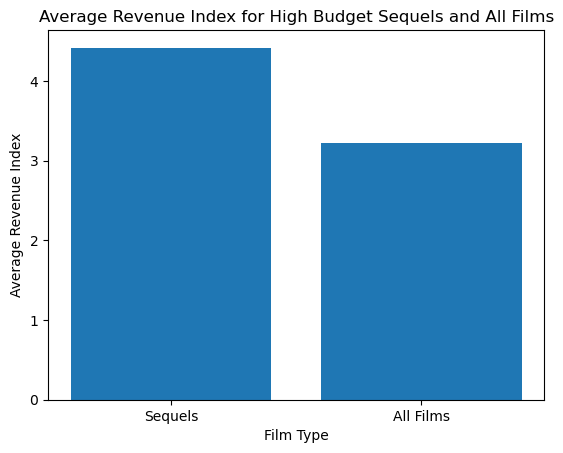

In [338]:
# Chart average Revenue Index for High Budget Sequels and All Films
plt.bar(['Sequels', 'All Films'], [average_revenue_index_sequels, average_revenue_index_all])
plt.xlabel('Film Type')
plt.ylabel('Average Revenue Index')
plt.title('Average Revenue Index for High Budget Sequels and All Films')

plt.savefig('imgs/Average Revenue Index for High Budget Sequels and All Films')
plt.show()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [299]:
# here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***